## Microlensing on Single Lens within SLSim
### Author: [Paras Sharma](https://github.com/timedilatesme)

Note that you need CUDA GPU support to run this code.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from slsim.Util.astro_util import theta_star_physical

from astropy.cosmology import FlatLambdaCDM

from astropy import units as u

from slsim.LOS.los_individual import LOSIndividual
from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.Lenses.lens import Lens

from slsim.ImageSimulation.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Util.param_util import gaussian_psf

from slsim.Plots.plot_functions import (
    plot_magnification_map,
    # plot_lightcurves_and_magmap,
)

from matplotlib import patches

### Define the Lens

In [2]:
def lens_instance_with_variability():
    # quasar and host galaxy dict. One can avoid host galaxy information and simulate
    # lensed quasar only.
    source_dict_quasar = {
        "z": 1.5,
        "angular_size": 0.10887651129362959,
        "ps_mag_i": 21,
        "ps_mag_r": 20,
        "ps_mag_g": 19,
        "ps_mag_z": 18,
        "ps_mag_y": 17,
        "mag_i": 20,
        "mag_r": 21,
        "mag_g": 22,
        "mag_z": 19,
        "mag_y": 18,
        "e1": 0.0,
        "e2": 0.0,
        "n_sersic": 1.5547096361698418,
        "center_x": 0.046053505877290584,
        "center_y": -0.09071283196326566,
    }

    deflector_dict_quasar = {
        "z": 0.501666913484551,
        "M": -21.83145200238993,
        "coeff": [0.141014265858706, 9.517770703665604e-05],
        "ellipticity": 0.2284277382812588,
        "physical_size": 4.206949315885421,
        "stellar_mass": 362262853208.36945,
        "angular_size": 0.6879678734773863,
        "mag_g": 21.867784201009997,
        "mag_r": 20.33108481157918,
        "mag_i": 19.493883022638812,
        "mag_z": 19.105662758016145,
        "mag_y": 18.86764491626696,
        "galaxy_type": "red",
        "vel_disp": 225.65292910480588,
        "e1_light": -0.11571475911179421,
        "e2_light": -0.0025994949173672476,
        "e1_mass": -0.17804791091757563,
        "e2_mass": 0.040020226664717634,
        "n_sersic": 4.0,
        "theta_E": 1.5,
        "gamma_pl": 2.0,
        "center_x": 0.0316789,
        "center_y": -0.0400549,
    }
    variable_agn_kwarg_dict = {
        "length_of_light_curve": 5000,
        "time_resolution": 1,
        "log_breakpoint_frequency": 1 / 20,
        "low_frequency_slope": 1,
        "high_frequency_slope": 3,
        "standard_deviation": 0.9,
    }
    kwargs_quasar = {
        "pointsource_type": "quasar",
        "extendedsource_type": "None",
        "variability_model": "light_curve",
        "kwargs_variability": {"agn_lightcurve", "i", "r", "g", "z", "y"},
        "agn_driving_variability_model": "bending_power_law",
        "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
        "lightcurve_time": np.linspace(0, 10000, 1000),
        "r_resolution": 500,
        "corona_height": 10,
    }

    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    source_quasar = Source(
        source_type="point_source",
        point_source_type="quasar",
        cosmo=cosmo,
        **source_dict_quasar,
        **kwargs_quasar,
    )
    deflector_quasar = Deflector(
        deflector_type="EPL_SERSIC",
        **deflector_dict_quasar,
    )

    los_class = LOSIndividual(
        kappa=-0.028113857977090363,
        gamma=[0.01118681739734637, -0.012498985117640523],
    )

    lens_class = Lens(
        source_class=source_quasar,
        deflector_class=deflector_quasar,
        cosmo=cosmo,
        los_class=los_class,
    )

    return lens_class


lens_class = lens_instance_with_variability()

### Setup the Microlensing Parameters (E.g. AGN Quasar)

In [21]:
band = "g"

# Einstein radius of a unit mass point lens in arcsec units.
theta_star, _, _ = theta_star_physical(
    z_lens=lens_class.deflector_redshift,
    z_src=lens_class.source_redshift_list[0],
    m=1,
    cosmo=lens_class.cosmo,
)
theta_star = theta_star.to(u.arcsec).value

# Print the microlensing parameters like kappa, kappa_star, gamma
kappa_star_images, kappa_tot_images, shear_images, shear_angle_images = (
    lens_class._microlensing_parameters_for_image_positions_single_source(
        band=band, source_index=0
    )
)
print("kappa_star_images: ", kappa_star_images)
print("kappa_tot_images:  ", kappa_tot_images)
print("shear_images:      ", shear_images)
print("shear_angle_images:", shear_angle_images, "radians")
print("theta_star:       ", theta_star, "arcsec")
print("deflector_redshift: ", lens_class.deflector_redshift)
print("source_redshift:    ", lens_class.source_redshift_list[0])

kwargs_MagnificationMap = {
    "theta_star": theta_star,  # arcsec
    "center_x": 0,  # arcsec
    "center_y": 0,  # arcsec
    "half_length_x": 2 * theta_star,  # arcsec
    "half_length_y": 2 * theta_star,  # arcsec
    "mass_function": "kroupa",
    "m_solar": 1.0,
    "m_lower": 0.08,
    "m_upper": 100,
    "num_pixels_x": 500,
    "num_pixels_y": 500,
}
kwargs_agn_source_morphology = {
    "source_redshift": lens_class.source_redshift_list[0],
    "cosmo": lens_class.cosmo,
    "r_out": 1000,
    "r_resolution": 1000,
    "smbh_mass_exp": 8,
    "inclination_angle": 0,
    "black_hole_spin": 0,
    # "observer_frame_wavelength_in_nm": 600,
    "observing_wavelength_band": band,
    "eddington_ratio": 0.1,
}

kwargs_microlensing = {
    "kwargs_MagnificationMap": kwargs_MagnificationMap,
    "point_source_morphology": "agn",
    "kwargs_source_morphology": kwargs_agn_source_morphology,
}

kappa_star_images:  [0.04866546 0.05681801 0.11962505 0.12708826]
kappa_tot_images:   [0.36058195 0.38686452 0.63741294 0.64748044]
shear_images:       [0.37412747 0.40103482 0.68145043 0.6874948 ]
shear_angle_images: [ 0.31036668  0.24000525 -2.61717942 -3.07422892] radians
theta_star:        1.9115980752342478e-06 arcsec
deflector_redshift:  0.501666913484551
source_redshift:     1.5


### Get the Light Curves

In [24]:
time_array = np.linspace(0, 10000, 1000)

mags_list_unlensed = lens_class.point_source_magnitude(
    band=band,
    lensed=False,
    time=time_array,
    microlensing=False,
)

mags_list_macrolensing = lens_class.point_source_magnitude(
    band=band,
    lensed=True,
    time=time_array,
    microlensing=False,
)

mags_list_microlensing = lens_class.point_source_magnitude(
    band=band,
    lensed=True,
    time=time_array,
    microlensing=True,
    kwargs_microlensing=kwargs_microlensing,
);

Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.
Generating magnification map ...
Done generating magnification map.


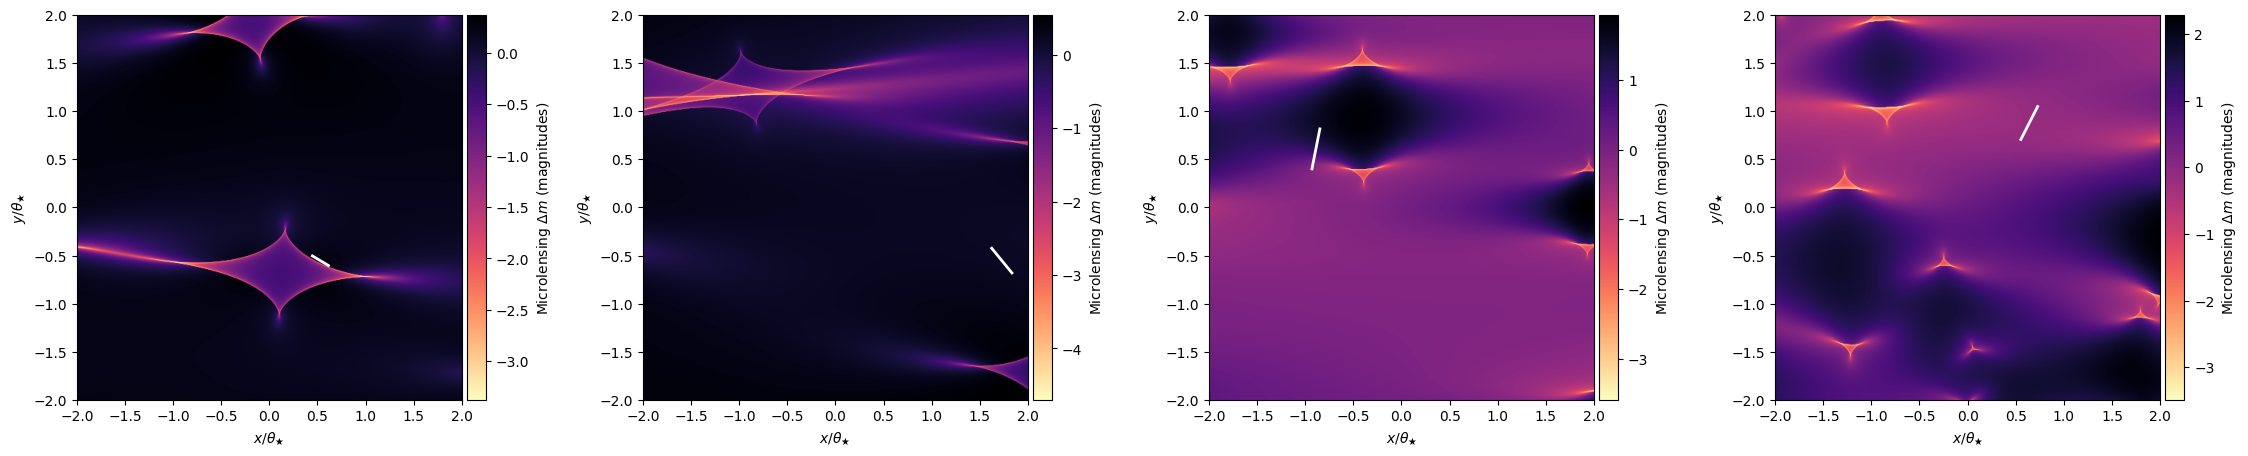

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(28, 5))

magmaps = lens_class.microlensing_model_class.magmaps_images
tracks = lens_class.microlensing_model_class.tracks

i = 0
for i in range(len(magmaps)):
    magmap = magmaps[i]
    track = tracks[i]
    plot_magnification_map(magmap, ax=ax[i], cmap="magma_r")

    # invert colorbar
    # cbar = ax[i].images[-1].colorbar
    # cbar.ax.invert_yaxis()

    # tracks are in pixel coordinates
    # to map them to the magmap coordinates, we need to convert them to the physical coordinates
    delta_x = 2 * magmap.half_length_x / magmap.num_pixels_x
    delta_y = 2 * magmap.half_length_y / magmap.num_pixels_y
    mid_x_pixel = magmap.num_pixels_x // 2
    mid_y_pixel = magmap.num_pixels_y // 2
    if track is not None:
        for j in range(len(track)):
            ax[i].plot(
                (track[j][1] - mid_x_pixel) * delta_x / magmap.theta_star,
                (track[j][0] - mid_y_pixel) * delta_y / magmap.theta_star,
                "w-",
                lw=2,
            )
            # ax[i].text(
            #     (track[j][1][0] - mid_x_pixel) * delta_x / magmap.theta_star,
            #     (track[j][0][0] - mid_y_pixel) * delta_y / magmap.theta_star,
            #     str(j + 1),
            #     color="white",
            #     fontsize=16,
            # )

    i += 1

In [26]:
print("mags_list_unlensed", mags_list_unlensed[0])
print("--" * 20)
print("mags_list_macrolensing", mags_list_macrolensing[0])
print("--" * 20)
print("mags_list_microlensing", mags_list_microlensing[0])

mags_list_unlensed 20.285525902520245
----------------------------------------
mags_list_macrolensing [[18.62785243 18.62785243 18.62785243 ... 19.11450999 19.14094957
  19.16996828]
 [18.38557199 18.38557199 18.38557199 ... 18.83622898 18.86008944
  18.88521677]
 [18.85974155 18.85974155 18.85974155 ... 19.2727204  19.2904897
  19.31154322]
 [18.90906982 18.90906982 18.90906982 ... 19.31919037 19.33695967
  19.35703339]]
----------------------------------------
mags_list_microlensing [[18.66907679 18.66855935 18.6680419  ... 18.55833967 18.58299981
  18.61023908]
 [18.57626568 18.57627733 18.57628897 ... 19.05467565 19.07857608
  19.10374338]
 [20.40368945 20.40321008 20.40273071 ... 19.1176181  19.13501369
  19.15569349]
 [18.77413998 18.77398937 18.77383875 ... 19.16776861 19.18576069
  19.2060572 ]]


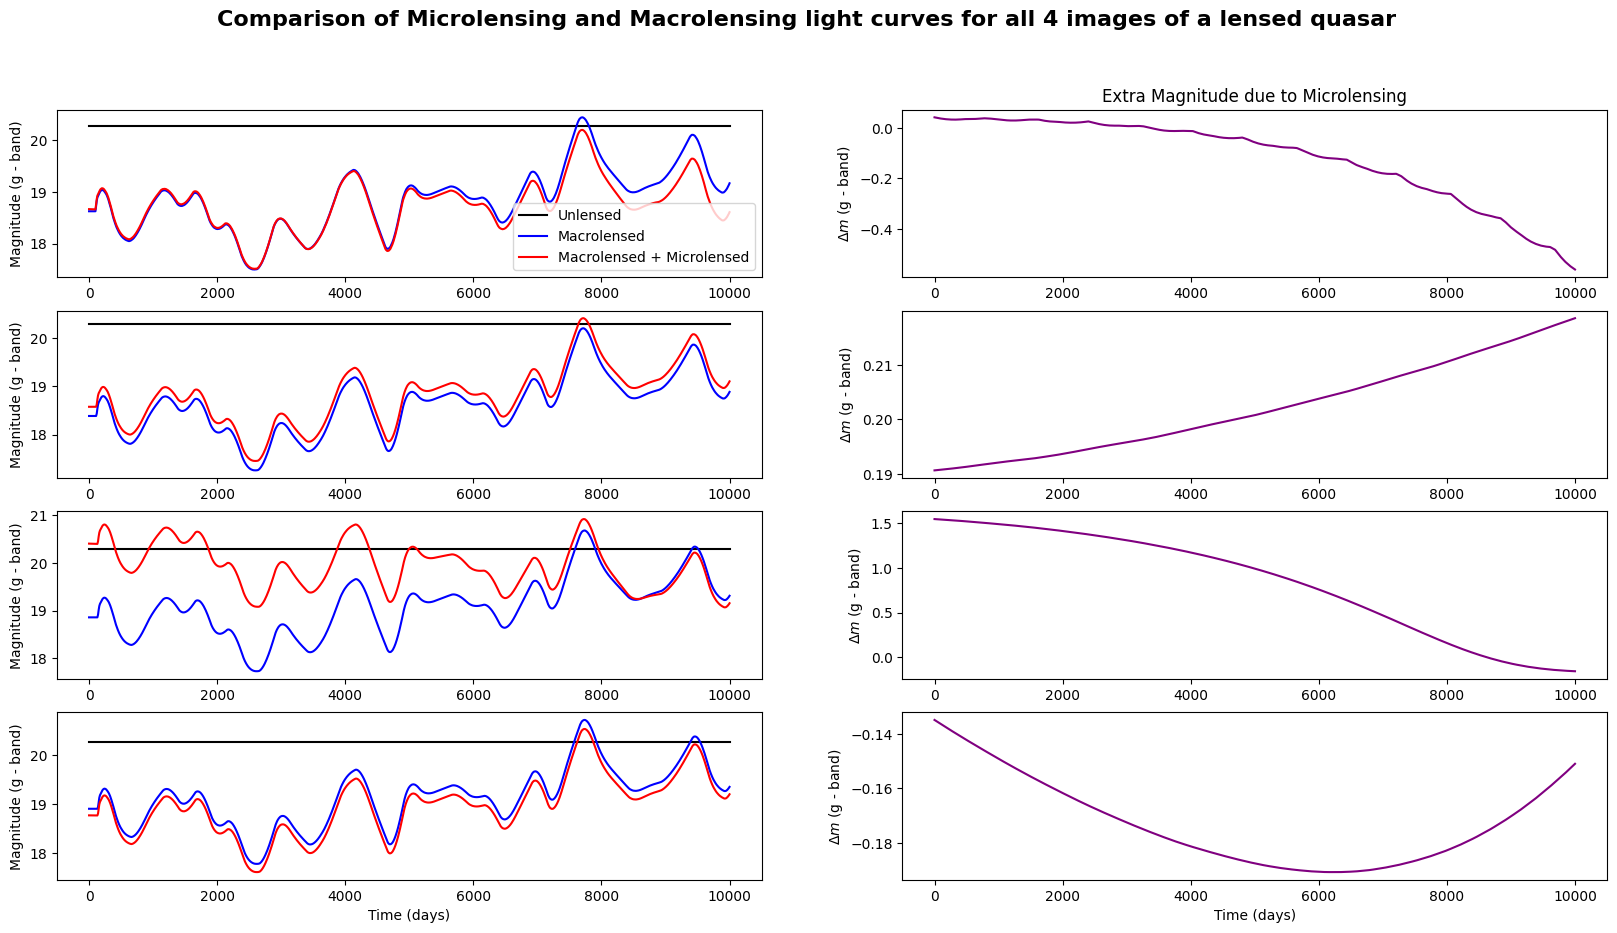

In [27]:
## Compare the light curves

fig, ax = plt.subplots(lens_class.image_number[0], 2, figsize=(20, 10))

for img_idx in range(lens_class.image_number[0]):
    # Unlensed
    ax[img_idx, 0].plot(
        time_array,
        mags_list_unlensed[0] * np.ones_like(time_array),
        label="Unlensed",
        color="black",
    )

    # Only Macrolensed
    ax[img_idx, 0].plot(
        np.tile(time_array, (len(mags_list_macrolensing[0]), 1))[img_idx],
        mags_list_macrolensing[0][img_idx],
        label="Macrolensed",
        color="blue",
    )
    # Both Macrolensed and Microlensed
    ax[img_idx, 0].plot(
        np.tile(time_array, (len(mags_list_microlensing[0]), 1))[img_idx],
        mags_list_microlensing[0][img_idx],
        label="Macrolensed + Microlensed",
        color="red",
    )
    ax[img_idx, 0].set_ylabel(f"Magnitude ({band} - band)")

    # Only Microlensing Magnitudes
    ax[img_idx, 1].plot(
        np.tile(time_array, (len(mags_list_microlensing[0]), 1))[img_idx],
        mags_list_microlensing[0][img_idx] - mags_list_macrolensing[0][img_idx],
        label="Microlensed",
        color="purple",
    )
    ax[img_idx, 1].set_ylabel(f"$\\Delta m$ ({band} - band)")

ax[0, 0].legend()
ax[3, 0].set_xlabel("Time (days)")

ax[0, 1].set_title("Extra Magnitude due to Microlensing")
ax[3, 1].set_xlabel("Time (days)")

fig.suptitle(
    f"Comparison of Microlensing and Macrolensing light curves for all {lens_class.image_number[0]} images of a lensed quasar",
    fontsize=16,
    fontweight="bold",
);

In [28]:
# make an image of this lens system as well
# load your psf kernel and transform matrix.
psf_kernel = gaussian_psf(fwhm=0.9, delta_pix=0.2, num_pix=41)

# let's set pixel to angle transform matrix.
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# These numbers come from some random dp0 cutout variance map. User can use their values.
bkg_std_i = (0.05774509,)  # i-band background noise
bkg_std_r = 0.03247451  # r-band background noise
bkg_std_g = 0.028600888  # g-band background noise

In [29]:
image_i = lens_image(
    lens_class=lens_class,
    band="i",
    mag_zero_point=27,  # lsst coadd images have zero point magnitude of 27.
    num_pix=61,
    psf_kernel=psf_kernel,
    transform_pix2angle=transform_matrix,
    exposure_time=300,  # one can provide None
    t_obs=None,
    std_gaussian_noise=bkg_std_i,  # one can provide None
    with_source=True,
    with_deflector=True,
)
image_r = lens_image(
    lens_class=lens_class,
    band="r",
    mag_zero_point=27,
    num_pix=61,
    psf_kernel=psf_kernel,
    transform_pix2angle=transform_matrix,
    exposure_time=300,
    t_obs=None,
    std_gaussian_noise=bkg_std_r,
    with_source=True,
    with_deflector=True,
)

image_g = lens_image(
    lens_class=lens_class,
    band="g",
    mag_zero_point=27,
    num_pix=61,
    psf_kernel=psf_kernel,
    transform_pix2angle=transform_matrix,
    exposure_time=300,
    t_obs=None,
    std_gaussian_noise=bkg_std_g,
    with_source=True,
    with_deflector=True,
)

In [30]:
# Simulate rgb color image
rgb_image = rgb_image_from_image_list([image_i, image_r, image_g], stretch=1)

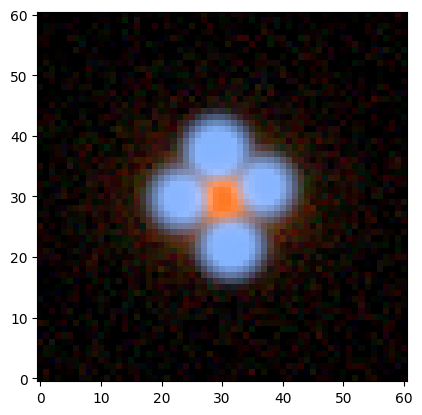

In [31]:
## see rgb image. You can also see images in each band.
plt.imshow(rgb_image, origin="lower")

### Combine Figures

/tmp/ipykernel_59154/1937002938.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


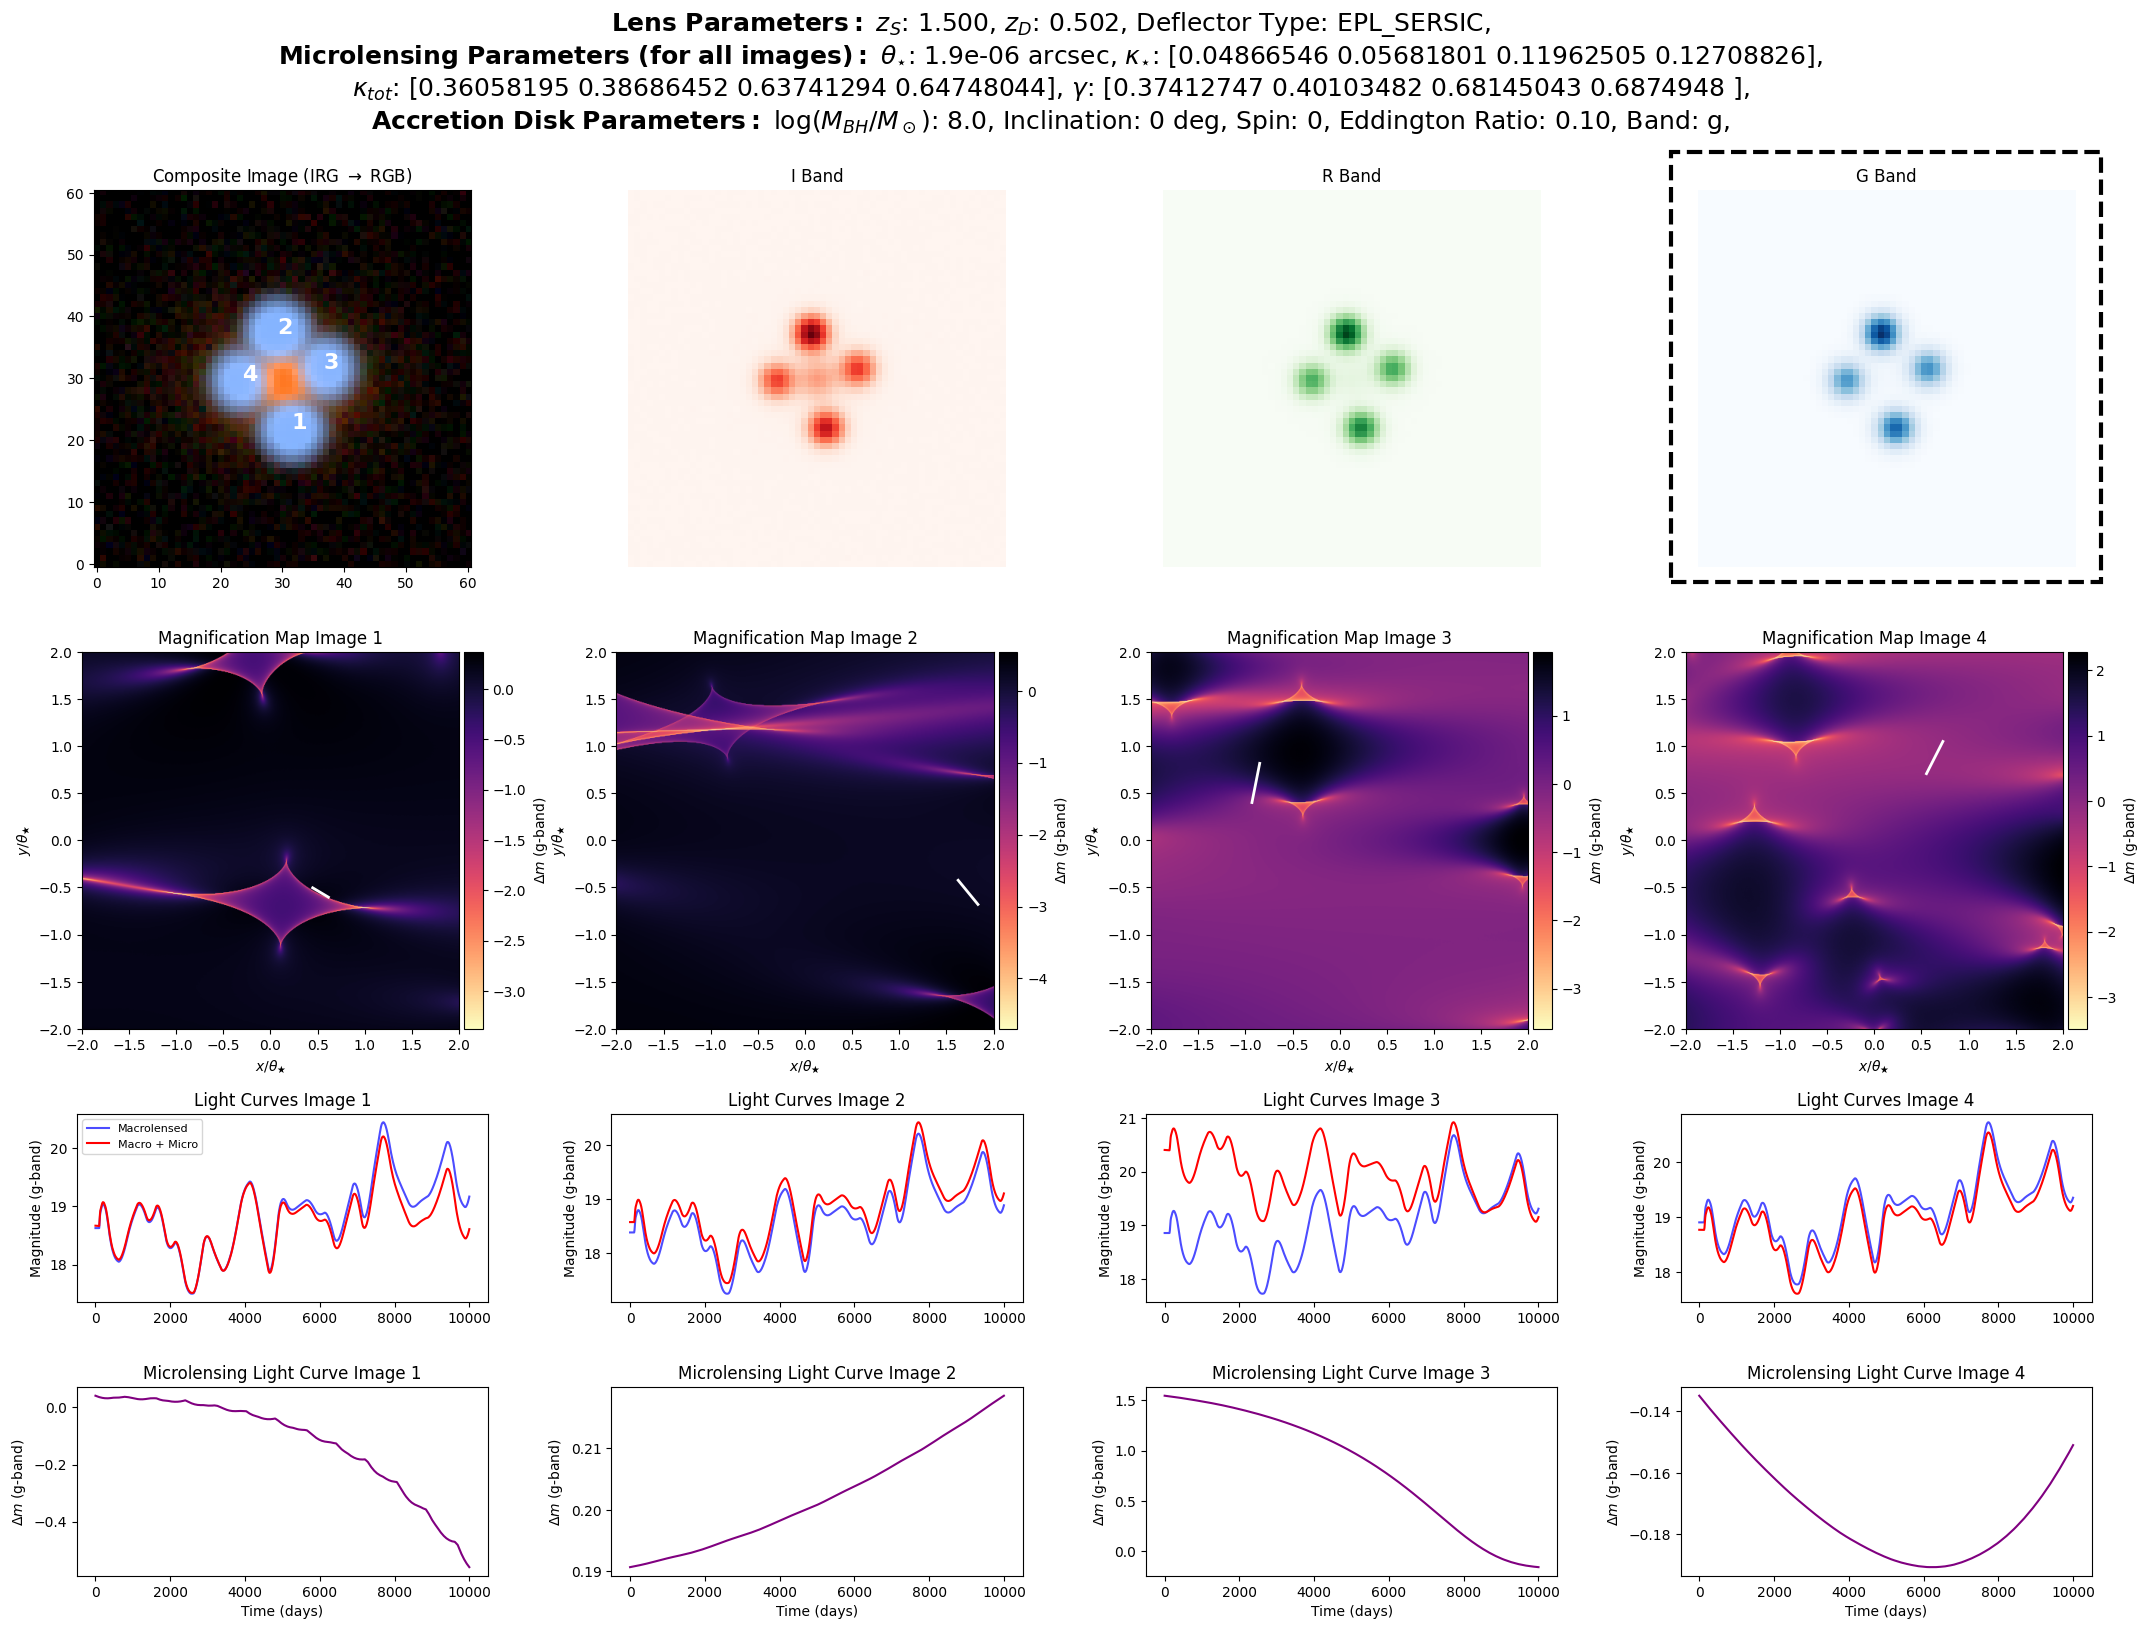

In [32]:
### LAYOUT ###

# RGB IMAGE                 #        BOXED I         #           R           #           G         #
# MAGMAPS WITH TRACKS 1 # MAGMAPS WITH TRACKS 2 # MAGMAPS WITH TRACKS 3 # MAGMAPS WITH TRACKS 4 #
# LIGHT CURVES IMAGE 1 # LIGHT CURVES IMAGE 2 # LIGHT CURVES IMAGE 3 # LIGHT CURVES IMAGE 4 #
# ML Light Curve 1 # ML Light Curve 2 # ML Light Curve 3 # ML Light Curve 4 #
# Create the combined figure with the specified layout
fig = plt.figure(figsize=(26, 18))

# Create a 4x4 grid with adjusted height ratios
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3, height_ratios=[1, 1, 0.5, 0.5])

# Row 1: RGB IMAGE, BOXED I, R, G
ax_rgb = fig.add_subplot(gs[0, 0])
ax_rgb.imshow(rgb_image, origin="lower")
ax_rgb.set_title("Composite Image (IRG $\\rightarrow$ RGB)")
# ax_rgb.axis("off")

# mark images 1 2 3 4
image_positions_x, image_positions_y = lens_class._ps_image_position_list[0]
# convert to pixel coordinates
image_positions_x = (
    np.array(image_positions_x) / transform_matrix[0, 0]
) + rgb_image.shape[0] // 2
image_positions_y = (
    np.array(image_positions_y) / transform_matrix[1, 1]
) + rgb_image.shape[1] // 2
for idx in range(len(image_positions_x)):
    ax_rgb.text(
        image_positions_x[idx],
        image_positions_y[idx],
        str(idx + 1),
        color="white",
        fontsize=16,
        weight="bold",
    )

ax_i = fig.add_subplot(gs[0, 1])
ax_i.imshow(image_i, origin="lower", cmap="Reds")
ax_i.set_title("I Band")
ax_i.axis("off")

ax_r = fig.add_subplot(gs[0, 2])
ax_r.imshow(image_r, origin="lower", cmap="Greens")
ax_r.set_title("R Band")
ax_r.axis("off")

ax_g = fig.add_subplot(gs[0, 3])
ax_g.imshow(image_g, origin="lower", cmap="Blues")
ax_g.set_title("G Band")
ax_g.axis("off")

# Row 2: MAGMAPS WITH TRACKS 1-4
for i in range(4):
    ax_mag = fig.add_subplot(gs[1, i])
    magmap = magmaps[i]
    track = tracks[i]

    plot_magnification_map(magmap, ax=ax_mag, cmap="magma_r")

    # Add tracks
    delta_x = 2 * magmap.half_length_x / magmap.num_pixels_x
    delta_y = 2 * magmap.half_length_y / magmap.num_pixels_y
    mid_x_pixel = magmap.num_pixels_x // 2
    mid_y_pixel = magmap.num_pixels_y // 2

    if track is not None:
        for j in range(len(track)):
            ax_mag.plot(
                (track[j][1] - mid_x_pixel) * delta_x / magmap.theta_star,
                (track[j][0] - mid_y_pixel) * delta_y / magmap.theta_star,
                "w-",
                lw=2,
            )
    ax_mag.set_title(f"Magnification Map Image {i+1}")

    cbar = ax_mag.images[-1].colorbar
    cbar.set_label("$\\Delta m$" + f" ({band}-band)", fontsize=10)

# Row 3: LIGHT CURVES IMAGE 1-4 (Combined macro+micro)
for img_idx in range(4):
    ax_lc = fig.add_subplot(gs[2, img_idx])
    # ax_lc.set_aspect(2)  # Set height to width ratio of 1:2

    # Unlensed
    # ax_lc.plot(time_array, mags_list_unlensed[0] * np.ones_like(time_array),
    #            label="Unlensed", color="black", alpha=0.7)

    # Macrolensed
    ax_lc.plot(
        np.tile(time_array, (len(mags_list_macrolensing[0]), 1))[img_idx],
        mags_list_macrolensing[0][img_idx],
        label="Macrolensed",
        color="blue",
        alpha=0.7,
    )

    # Macro + Microlensed
    ax_lc.plot(
        np.tile(time_array, (len(mags_list_microlensing[0]), 1))[img_idx],
        mags_list_microlensing[0][img_idx],
        label="Macro + Micro",
        color="red",
    )

    ax_lc.set_ylabel(f"Magnitude ({band}-band)")
    ax_lc.set_title(f"Light Curves Image {img_idx+1}")
    if img_idx == 0:
        ax_lc.legend(fontsize=8)

# Row 4: ML Light Curve 1-4 (Microlensing only)
for img_idx in range(4):
    ax_ml = fig.add_subplot(gs[3, img_idx])
    # ax_ml.set_aspect(2)  # Set height to width ratio of 1:2

    # Only Microlensing effect
    ax_ml.plot(
        np.tile(time_array, (len(mags_list_microlensing[0]), 1))[img_idx],
        mags_list_microlensing[0][img_idx] - mags_list_macrolensing[0][img_idx],
        label="Microlensing",
        color="purple",
    )

    ax_ml.set_ylabel(f"$\\Delta m$ ({band}-band)")
    ax_ml.set_xlabel("Time (days)")
    ax_ml.set_title(f"Microlensing Light Curve Image {img_idx+1}")


##########################################################################
## make a dotted box around the band- band image to highlight it

# identify the axes for the band-band image
if band == "i":
    ax_band = ax_i
if band == "r":
    ax_band = ax_r
if band == "g":
    ax_band = ax_g

rect = patches.Rectangle(
    xy=(-0.07, -0.04),  # Bottom-left corner
    width=1.14,  # 100% of the axes width
    height=1.14,  # 100% of the axes height
    transform=ax_band.transAxes,  # Use the axes' own coordinate system
    linewidth=3,
    linestyle="--",  # Dotted or dashed line
    edgecolor="k",
    facecolor="none",
    clip_on=False,  # Ensures the line isn't clipped by the axes boundary
)
ax_band.add_patch(rect)
##########################################################################


##########################################################################
# in suptitle add details about the accretion disk and microlensing parameters in LaTeX format
plt.suptitle(
    r"$\bf{Lens \ Parameters}:$ "
    f"$z_S$: {lens_class.source_redshift_list[0]:.3f}, "
    f"$z_D$: {lens_class.deflector_redshift:.3f}, "
    f"Deflector Type: {lens_class.deflector.deflector_type}, "
    "\n"
    r"$\bf{Microlensing \ Parameters \ (for \ all \ images)}:$ "
    "$\\theta_{\\star}$: " + f"{theta_star:.1e} arcsec, "
    f"$\\kappa_{{\\star}}$: {kappa_star_images}, "
    "\n"
    f"$\\kappa_{{tot}}$: {kappa_tot_images}, "
    f"$\\gamma$: {shear_images}, "
    "\n"
    r"$\bf{Accretion \ Disk \ Parameters}:$ "
    "$\\log(M_{BH}/M_\\odot)$: "
    + f"{kwargs_agn_source_morphology['smbh_mass_exp']:.1f}, "
    f"Inclination: {kwargs_agn_source_morphology['inclination_angle']} deg, "
    f"Spin: {kwargs_agn_source_morphology['black_hole_spin']}, "
    f"Eddington Ratio: {kwargs_agn_source_morphology['eddington_ratio']:.2f}, "
    f"Band: {kwargs_agn_source_morphology['observing_wavelength_band']}, ",
    fontsize=18,
)

# default rcParams for matplotlib
# plt.rcParams.update(plt.rcParamsDefault)

# make all text bigger so that it is readable in the paper
# plt.rcParams.update({'font.size': 18})

# Adjust layout to prevent overlap
# fig.subplots_adjust(top=0.9, bottom=0.05, left=0.05, right=0.95)


plt.tight_layout()
plt.show()


# save the figure as a pdf file
# fig.savefig("slsim_microlensing_example.pdf", bbox_inches='tight', dpi=300)